# Pipeline example
## Computing: 
* A
* Masks
* Masks + procedure
* ...

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from matplotlib import pyplot as plt
from helpers import *

import style_transfer

config = tf.ConfigProto()

def reset():
    tf.reset_default_graph()
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.4

In [2]:
import tensorflow as tf
import vgg19

In [3]:
tf.reset_default_graph()
sess = tf.Session()

vgg = vgg19.Vgg19(VGG_PATH + 'vgg19.npy')
vgg_shape = [1, None, None, 3]

images = tf.placeholder("float", vgg_shape, name="images")
vgg.build(images)


In [4]:
im_content = load_image2("data/catndogs/1.jpg", width=448)
im_style = load_image2("data/catndogs/2.jpg", height=im_content.shape[0], width=im_content.shape[1])

In [5]:
dict_content = eval_layers(sess, im_content, vgg, ["conv4_1", "conv4_4", "conv3_1", "conv5_1", "conv2_1", "conv5_4"])
layer_1 = dict_content.get("conv4_4")
layer_141 = dict_content.get("conv4_1")
layer_131 = dict_content.get("conv3_1")
layer_151 = dict_content.get("conv5_1")
layer_121 = dict_content.get("conv2_1")
layer_154 = dict_content.get("conv5_4")


dict_content = eval_layers(sess, im_style, vgg, ["conv4_1", "conv4_4", "conv3_1", "conv5_1", "conv2_1", "conv5_4"])
layer_2 = dict_content.get("conv4_4")
layer_241 = dict_content.get("conv4_1")
layer_231 = dict_content.get("conv3_1")
layer_251 = dict_content.get("conv5_1")
layer_221 = dict_content.get("conv2_1")
layer_254 = dict_content.get("conv5_4")


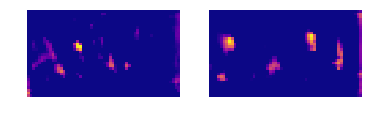

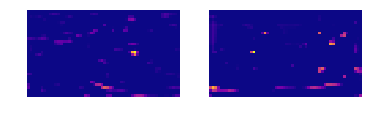

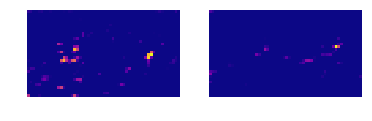

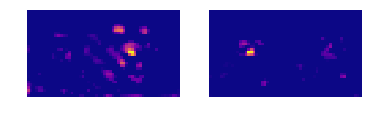

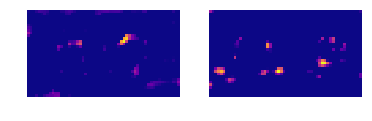

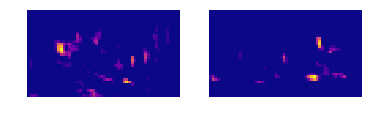

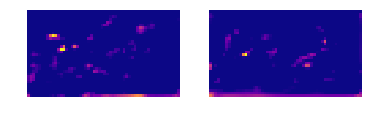

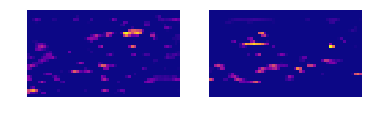

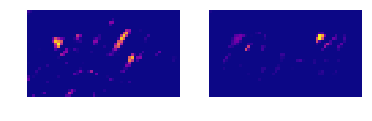

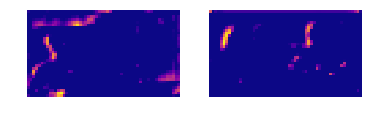

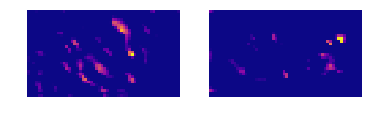

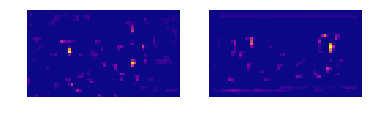

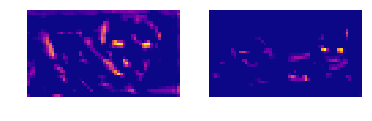

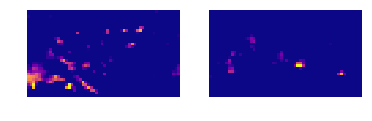

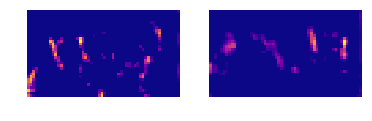

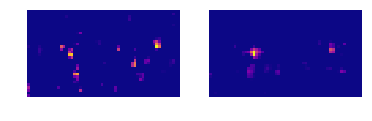

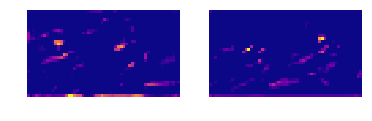

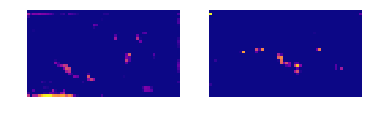

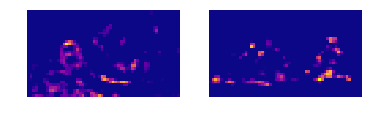

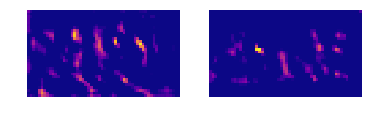

In [6]:
for k in range(0, 20):
    plt.figure(figsize=(6,6))
    ax = plt.subplot(2,2,1)
    ax.imshow(layer_1[0][:,:,k], cmap="plasma", interpolation="nearest")
    plt.axis('off')
    ax = plt.subplot(2,2,2)
    ax.imshow(layer_2[0][:,:,k], cmap="plasma", interpolation="nearest")
    plt.axis('off')

In [7]:
s = np.sum(layer_1, axis=3)
d = np.sum(layer_2, axis=3)

88564.969

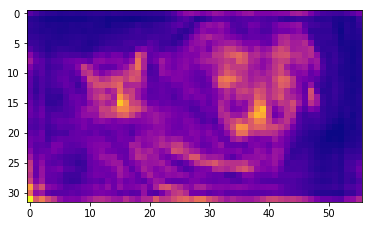

In [8]:
plt.imshow(s[0], cmap="plasma")
s.max()

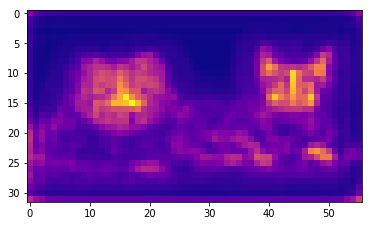

In [9]:
plt.imshow(d[0], cmap="plasma")

In [10]:
A = compute_affinity_matrix(layer_154, layer_254)


(-0.5, 447.5, 447.5, -0.5)

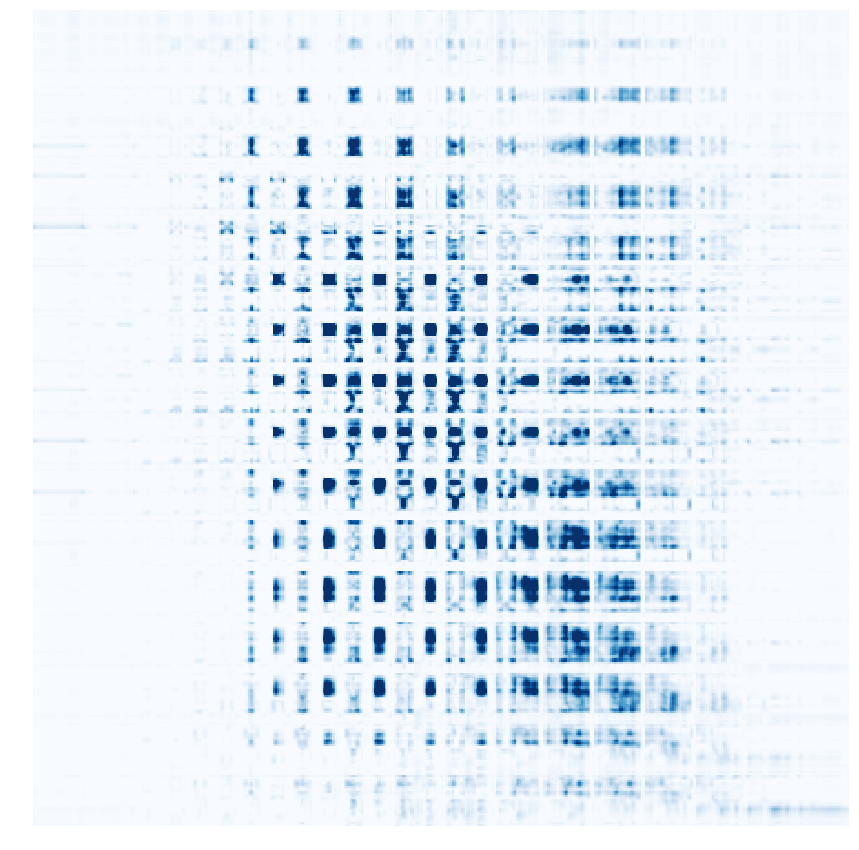

In [11]:
'''plt.figure(figsize=(15,15))
plt.imshow(A, cmap="Blues")
plt.axis("off")
'''

plt.figure(figsize=(15,15))
plt.imshow(A / A.max(), cmap="Blues", vmax=0.075)
plt.axis("off")


In [122]:
normalized = True
K=10
L,R = get_masks(K, A, layer_154.shape[1:3], layer_254.shape[1:3], normalize=normalized)

L_all = L.sum(axis=0)
#L_mean = L_all.mean()
#L_std = L_all.std()
L_all /= L_all.max()
L_orphan = 1 - L_all
L = np.concatenate((L, L_orphan[None, ...]))

R_all = R.sum(axis=0)
R_all /= R_all.max()
R_orphan = 1 - R_all
R = np.concatenate((R, R_orphan[None, ...]))



Computing 10 masks


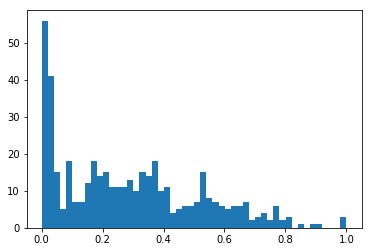

In [109]:
plt.hist(L_all.flatten(), bins=50);

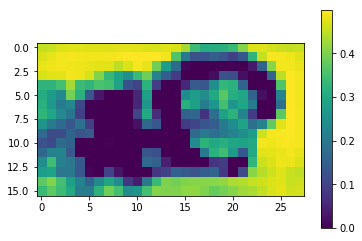

In [121]:
plt.imshow(np.maximum((1 - L_all - 0.5), 0) )
plt.colorbar()

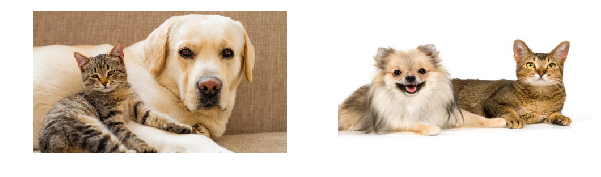

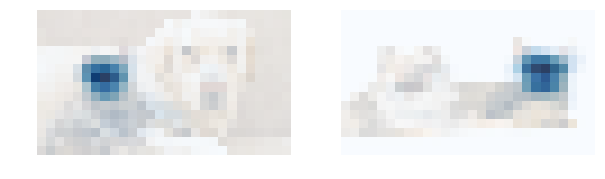

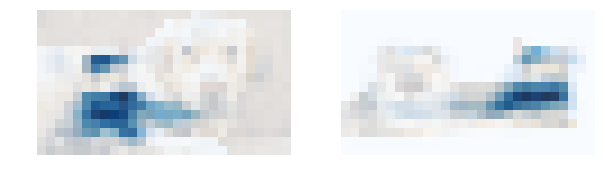

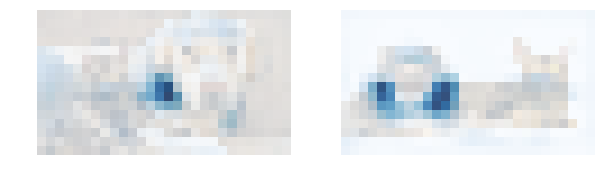

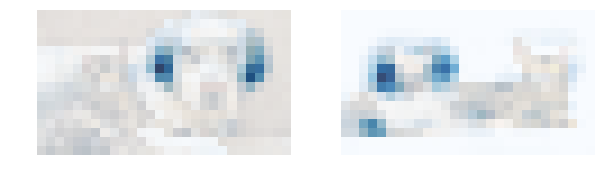

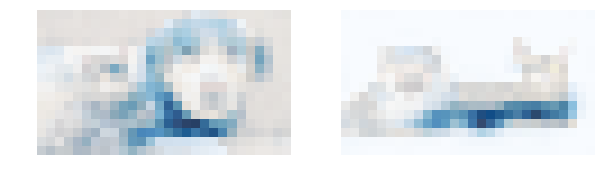

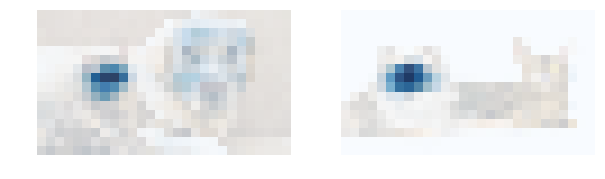

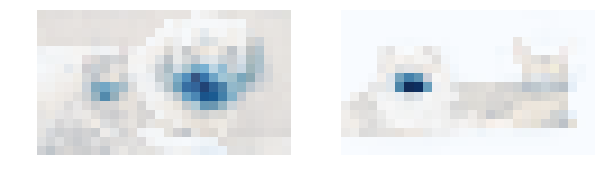

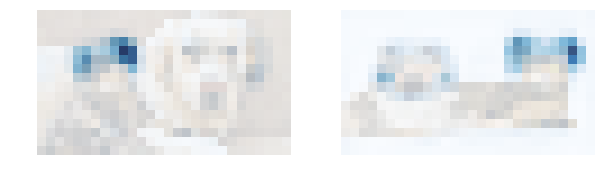

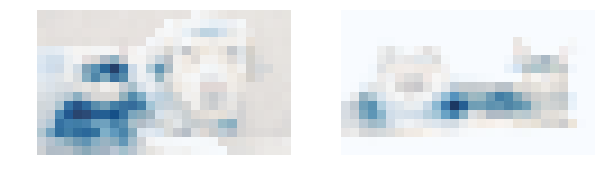

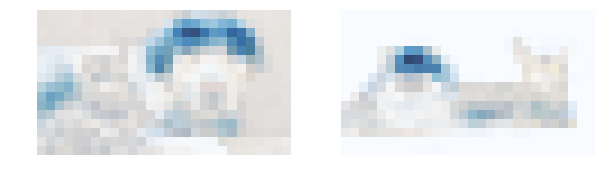

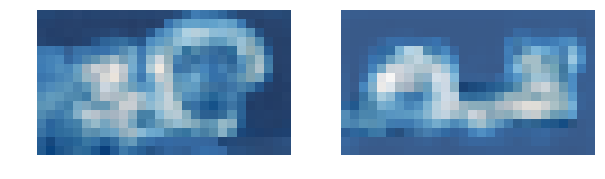

In [101]:
show_masks(im_content, im_style, L, R, K+1, normalized=normalized, show_original=True)

In [59]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax
import numpy as np
import scipy
import scipy.ndimage


def refine_mask(mask_in=None):
    mask_in = mask_in.astype(np.uint8)
    mask_out = scipy.ndimage.morphology.binary_fill_holes(mask_in)  ## fill in the holes
    return mask_out

crf_params = {}
crf_params['sxy'] = (30, 30)
crf_params['srgb'] = (3, 3, 3)
crf_params['compat'] = 3
crf_params['d_infer'] = 5

def dcrf_refine(img, mask):
    img_sz = img.shape[0:2]
    if img_sz[0] != mask.shape[0]:
        mask = skimage.transform.resize(mask, img_sz, mode='constant', order=1)
        plt.figure()
        plt.imshow(mask)

    ## refine with CRF
    labels_c = mask[None]  # labels.reshape((1,img_sz[0],img_sz[1]))
    labels_c = np.concatenate([1 - labels_c, labels_c], axis=0)
    d = dcrf.DenseCRF2D(img_sz[1], img_sz[0], 2)
    U = unary_from_softmax(labels_c, scale=0.6)
    d.setUnaryEnergy(U)
    
    d.addPairwiseBilateral(sxy=crf_params['sxy'], srgb=crf_params['srgb'], rgbim=img.astype(np.uint8),
                           compat=crf_params['compat'],
                           kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    Q = d.inference(crf_params['d_infer'])
    Q = np.array(Q)[0]
    labels_c = refine_mask(Q.reshape(img_sz) < 0.5)
    return labels_c

In [60]:
threshold = 0.5
#Lt = np.where(L > threshold, 1.0, 0.0)
#Rt = np.where(R > threshold, 1.0, 0.0)

Lt = np.where(L > threshold, L, 0.0)
Rt = np.where(R > threshold, R, 0.0)


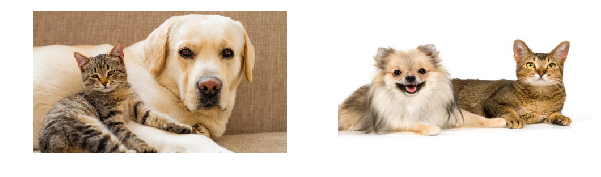

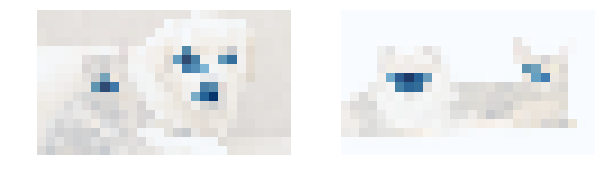

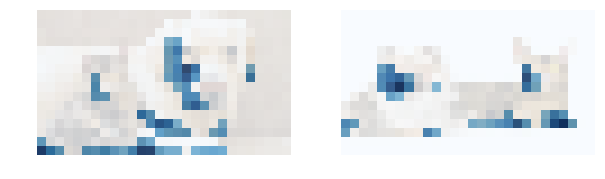

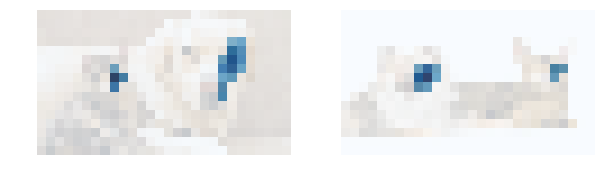

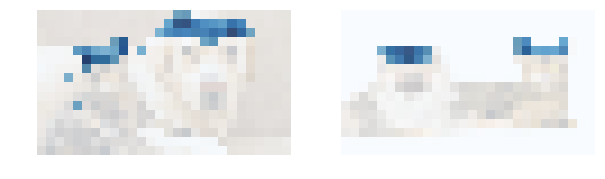

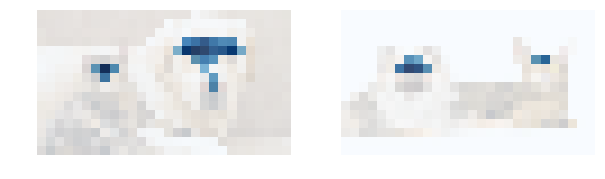

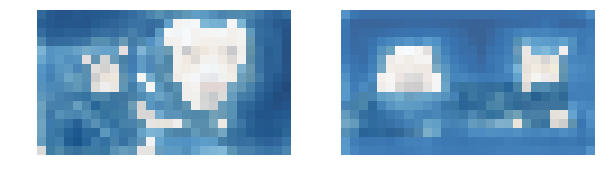

In [61]:
show_masks(im_content, im_style, Lt, Rt, K+1, normalized=normalized, show_original=True)

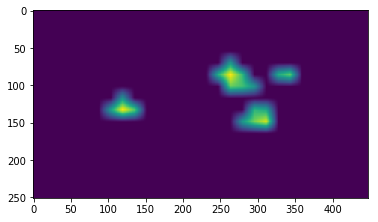

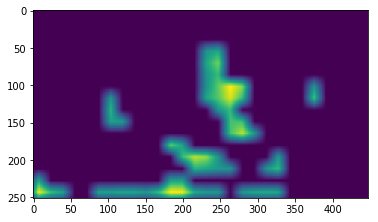

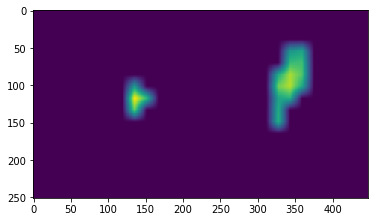

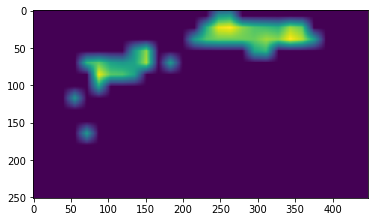

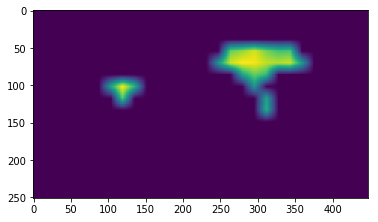

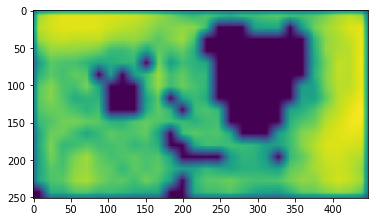

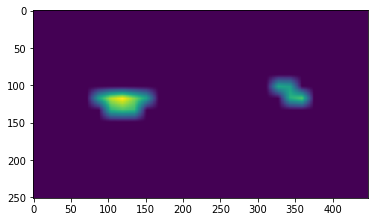

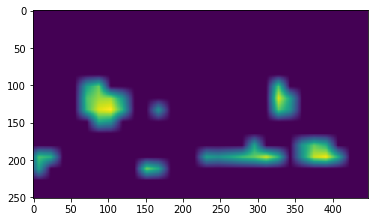

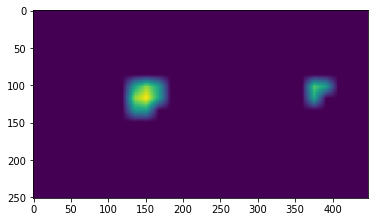

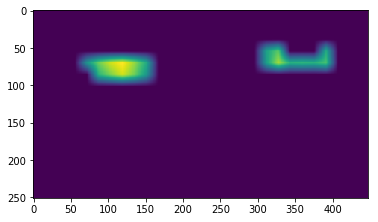

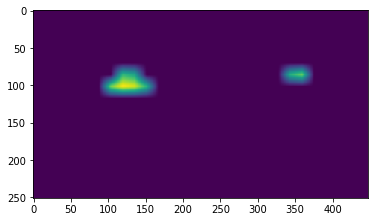

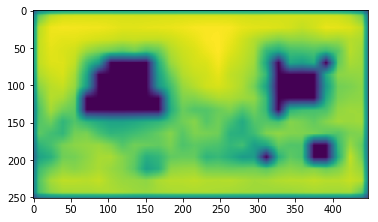

In [62]:
L2 = [dcrf_refine(im_content*255, l) for l in Lt]
R2 = [dcrf_refine(im_style*255, r) for r in Rt]

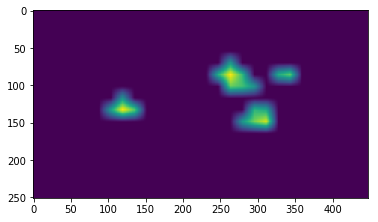

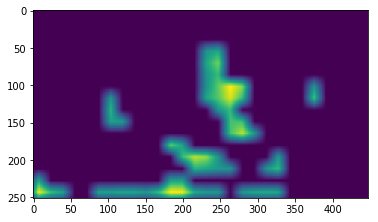

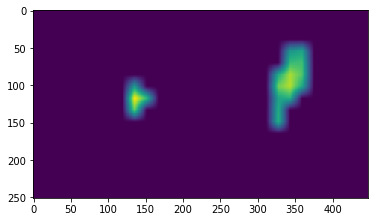

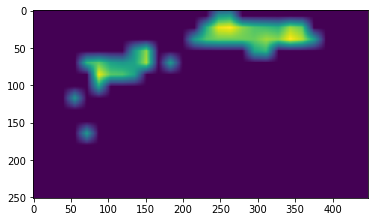

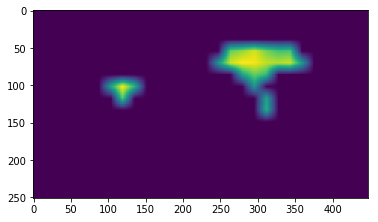

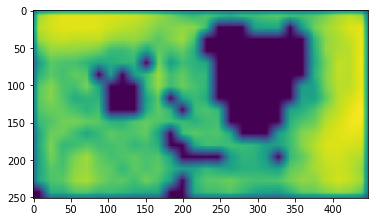

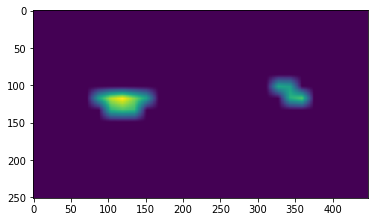

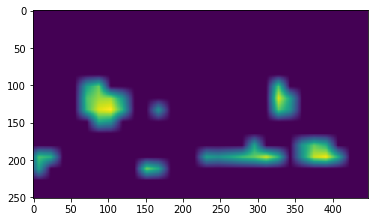

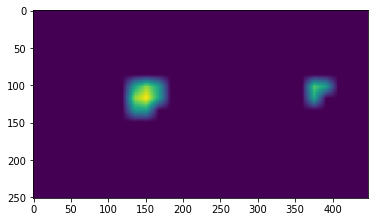

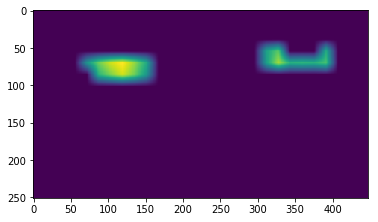

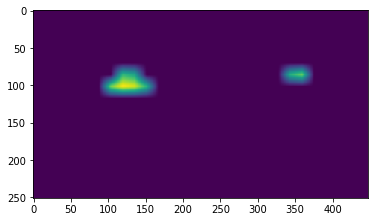

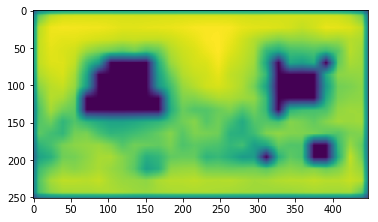

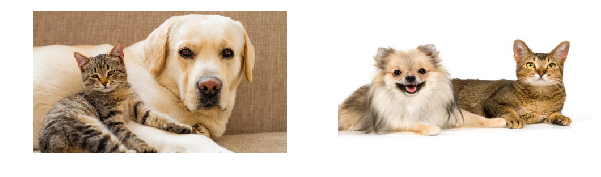

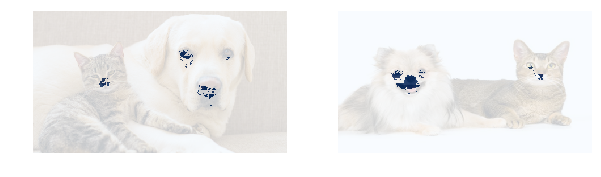

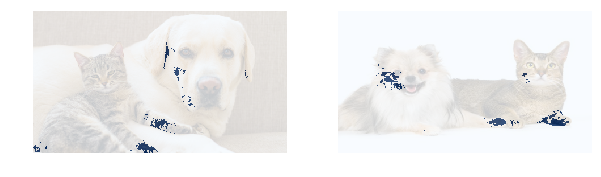

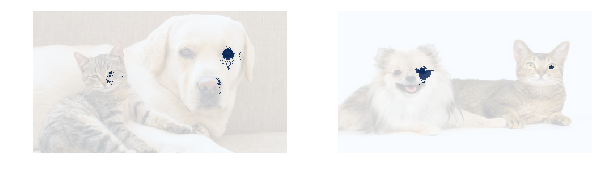

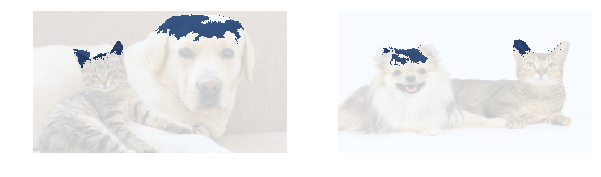

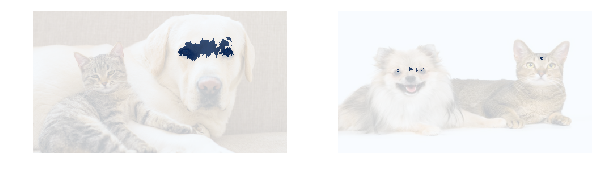

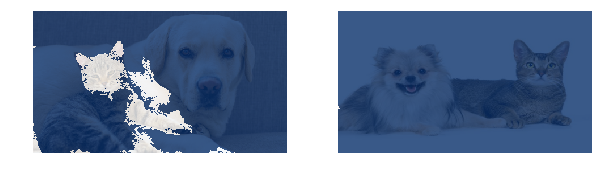

In [63]:
L2 = [dcrf_refine(im_content*255, l) for l in Lt]
R2 = [dcrf_refine(im_style*255, r) for r in Rt]
show_masks(im_content, im_style, L2, R2, K+1, normalized=normalized, show_original=True)

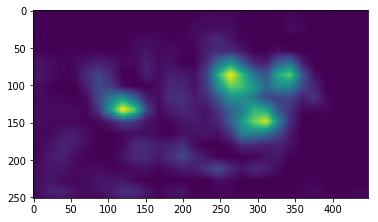

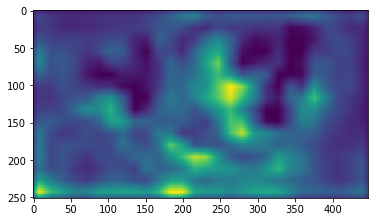

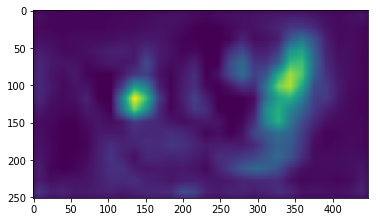

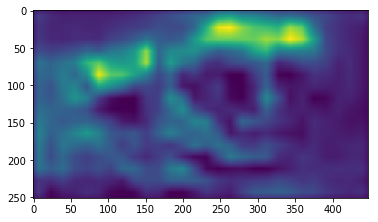

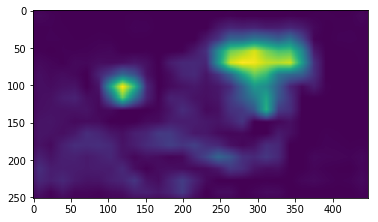

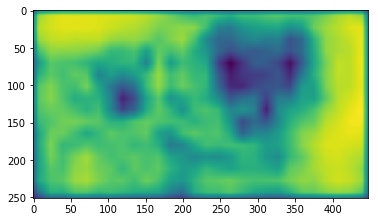

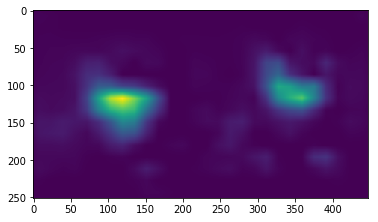

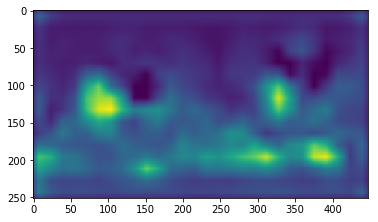

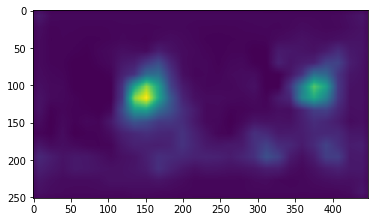

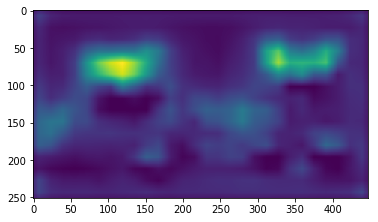

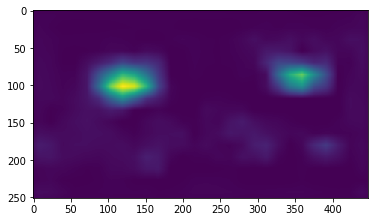

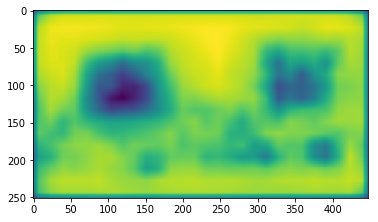

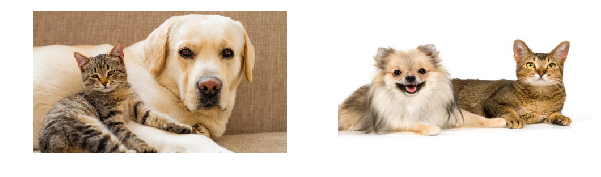

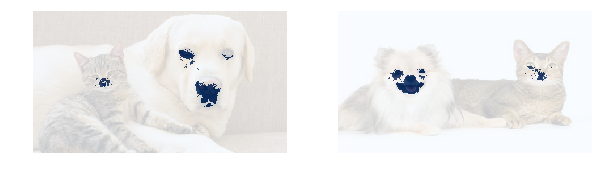

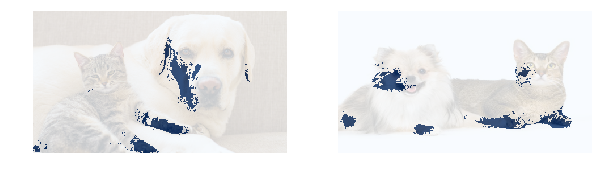

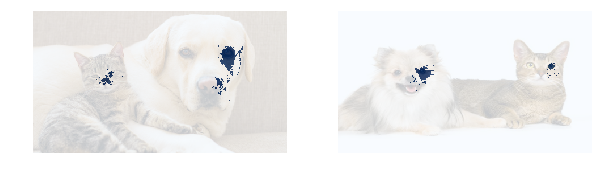

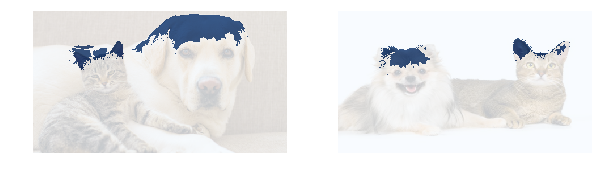

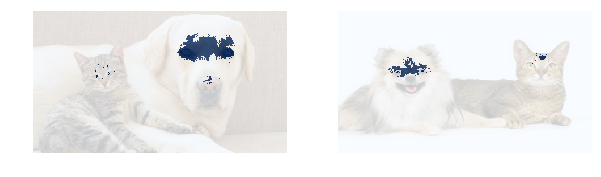

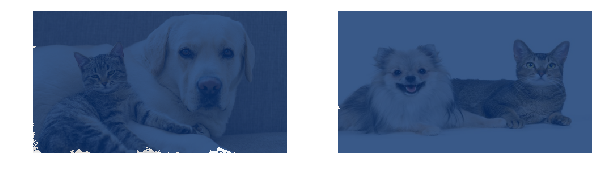

In [64]:
L2 = [dcrf_refine(im_content*255, l) for l in L]
R2 = [dcrf_refine(im_style*255, r) for r in R]
show_masks(im_content, im_style, L2, R2, K+1, normalized=normalized, show_original=True)

In [89]:
normalized = False
K=10
L,R = get_masks(K, A, layer_154.shape[1:3], layer_254.shape[1:3], normalize=True, orphan=False)

L.max()

Computing 10 masks


1.0

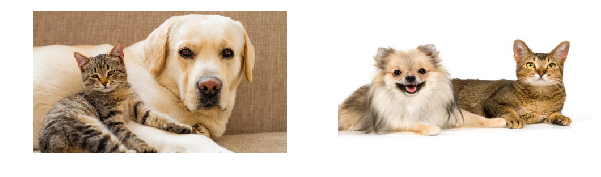

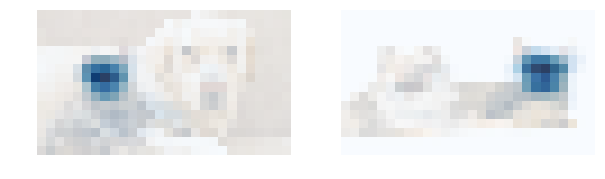

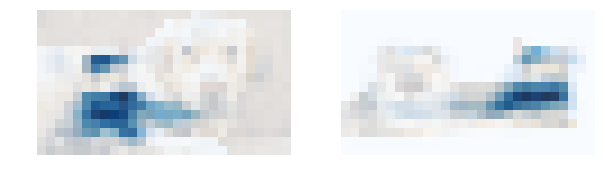

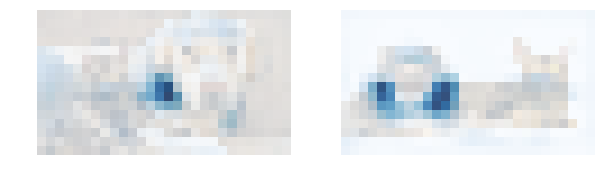

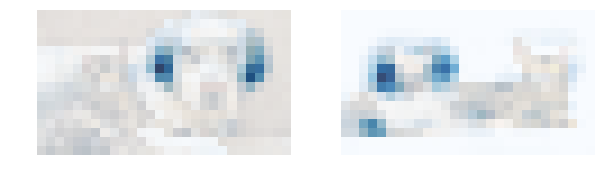

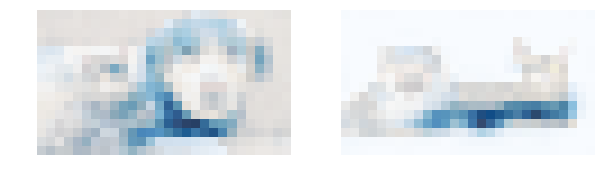

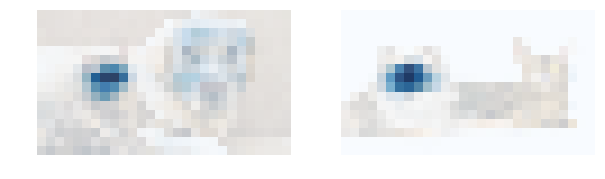

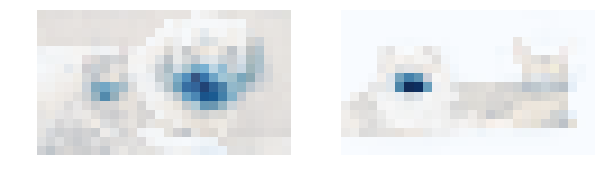

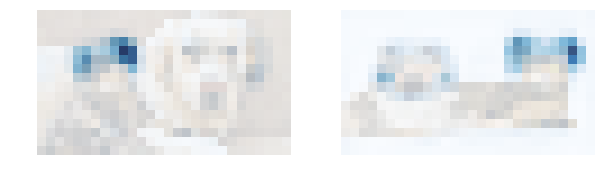

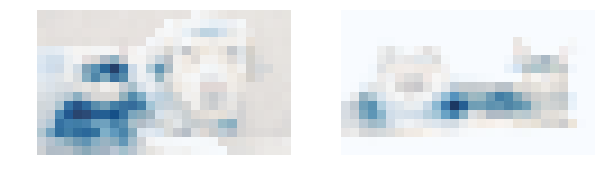

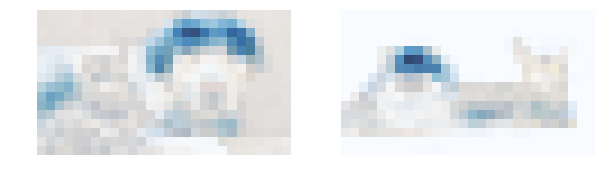

In [91]:
show_masks(im_content, im_style, L, R, K, normalized=True, show_original=True, vmax=1)

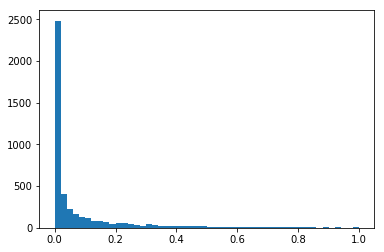

In [92]:
plt.hist(L.flatten(),bins=50);

In [93]:
L_orphan = np.ones(L[1].shape)*L.mean()
R_orphan = np.ones(R[1].shape)*R.mean()

L = np.concatenate((L, L_orphan[None, ...]))
R = np.concatenate((R, R_orphan[None, ...]))


In [94]:
from sklearn.utils.extmath import softmax

In [103]:
temp=0.1
Lsm = softmax(L.reshape((L.shape[0],-1)).transpose()/temp).transpose().reshape(L.shape)
Rsm = softmax(R.reshape((R.shape[0],-1)).transpose()/temp).transpose().reshape(R.shape)

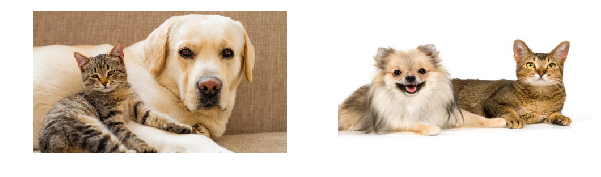

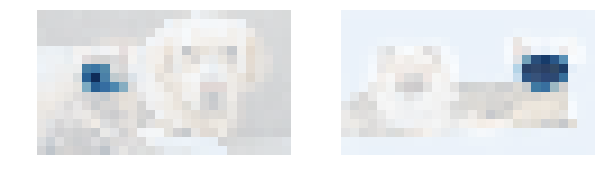

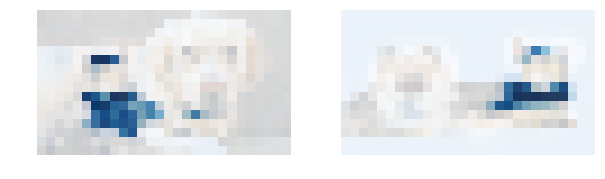

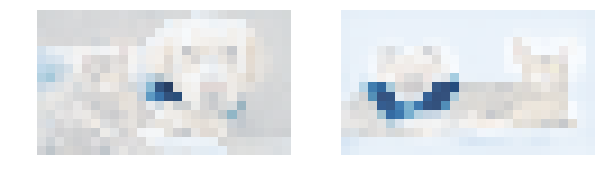

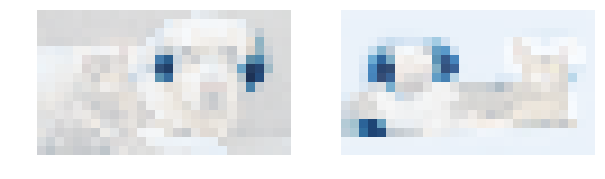

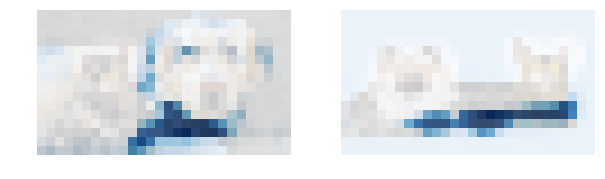

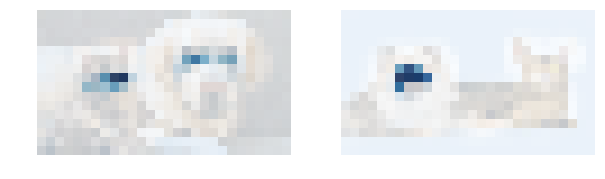

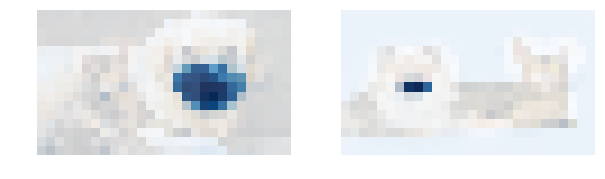

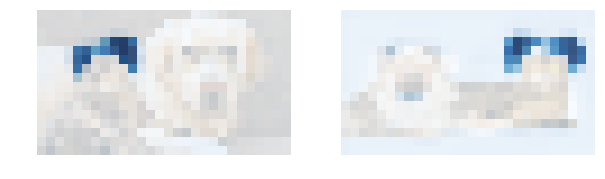

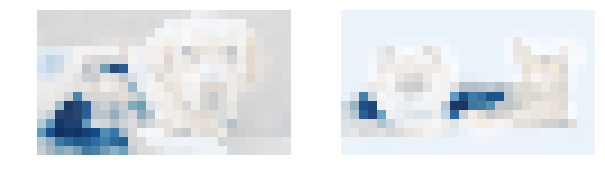

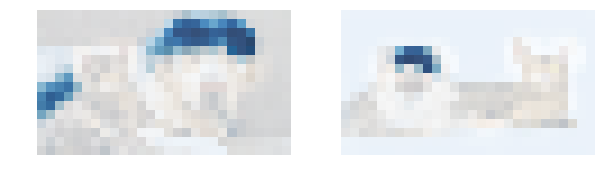

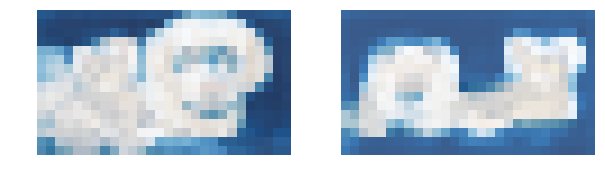

In [105]:
show_masks(im_content, im_style, Lsm, Rsm, K+1, normalized=False, show_original=True, vmax=1)

In [18]:
W = np.array([softmax(A[i, None]) for i in range(A.shape[0])])
W.shape

(448, 1, 448)

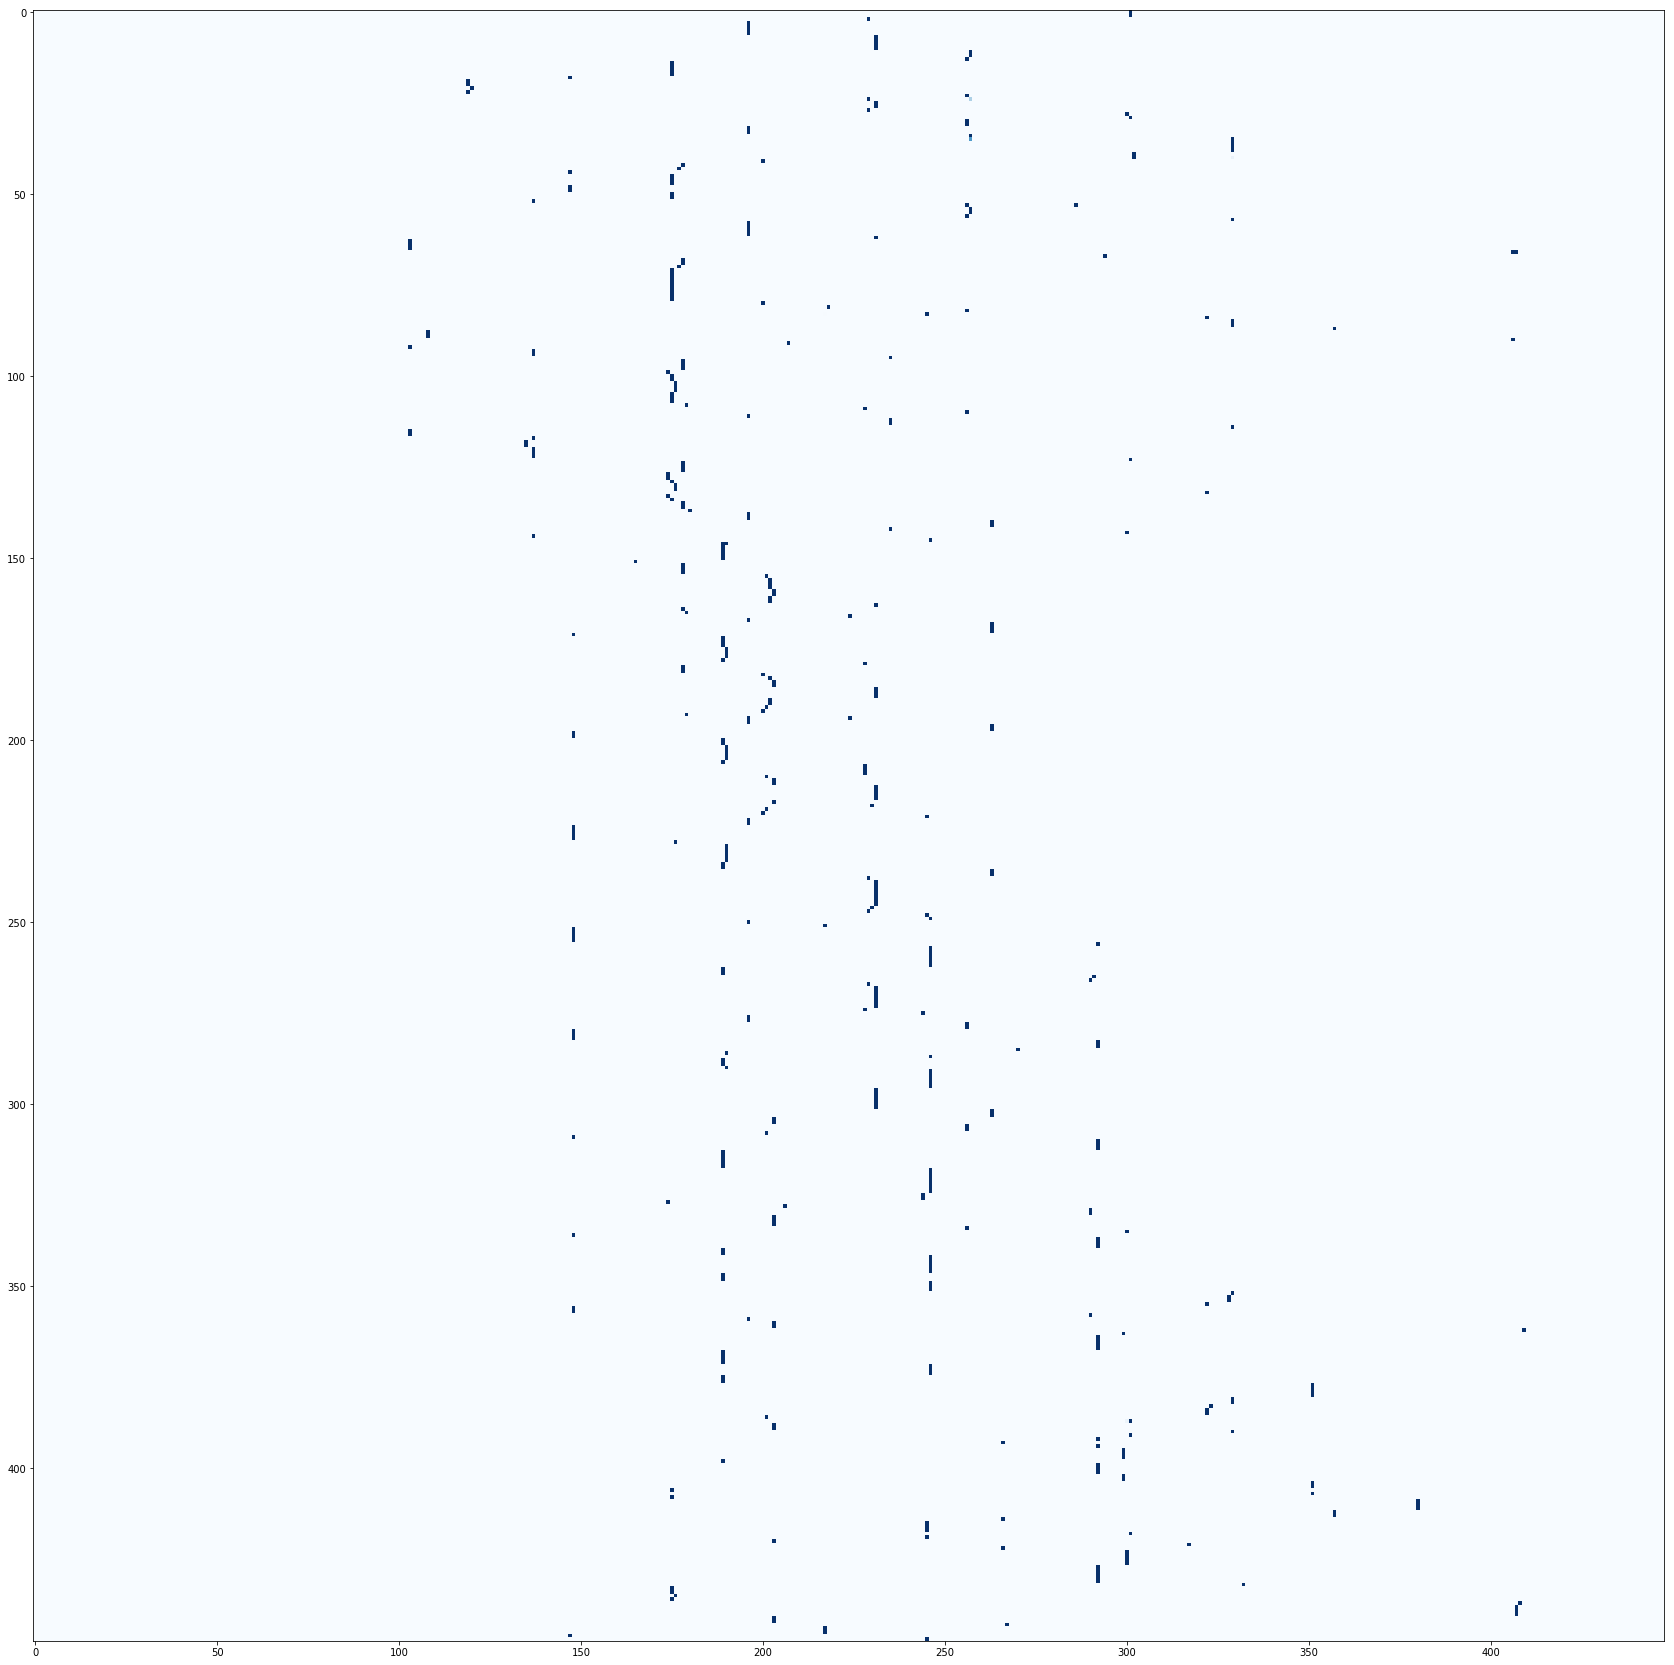

In [21]:
plt.figure(figsize=(30,30))
plt.imshow(W[:,0,:], cmap="Blues", vmax=0.00075)